# Проект "Промышленность"

# Описание проекта

По заданию ООО «Так закаляем сталь» мы будем строить модель, которая предскажет температуру стали, производимой ООО «Так закаляем сталь», которая позволит этому металлургическому комбинату сократить потребление электроэнергии и соответственно производственные расходы.


1. Проведем исследовательский анализ данных, имеющихся в нашем распоряжении.

1.1. Добавим библиотеки (потом добавим отстальные, это пока только для исследовательского анализа) и прочитаем файлы

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [2]:
# чтение имеющихся в нашем распряжении файлов 
df_arc = pd.read_csv('/datasets/data_arc_new.csv')
df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
df_gas = pd.read_csv('/datasets/data_gas_new.csv')
df_temp = pd.read_csv('/datasets/data_temp_new.csv')
df_wire = pd.read_csv('/datasets/data_wire_new.csv')
df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
RANDOM_STATE = 310723

1.2. Рассмотрим подробнее каждую из таблиц

А. данные об электродах

In [3]:
display(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [4]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
df_arc.isna().sum() #проверим пропуски

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

В данных об электродах представлены время нагрева, а также  активная и реактивная мощности. Вероятно, в дальнейшем эти данные будут актуальны для нашего иссследования.

In [6]:
#посчитаем общую можность по формуле и добавим столбец с соответствующим значением
df_arc['Общая_мощность'] = (df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)**0.5
print(df_arc.head())

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  Общая_мощность  
0             0.211253        0.371123  
1             0.477438        0.902319  
2             0.430460        0.722536  
3             0.379979        0.642824  
4             0.643691        1.079934  


Сделаем график, чтобы посмотреть выбросы

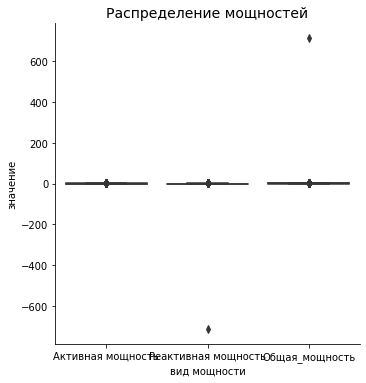

In [7]:
sns.catplot(kind="box", data=df_arc[['Активная мощность', 'Реактивная мощность','Общая_мощность']], palette='viridis', height=5)
plt.title('Распределение мощностей', fontsize=14)
plt.xlabel('вид мощности')
plt.ylabel('значение')
plt.show()

Есть выбросы на значениях менее -600 и более 600, в дальнейшем удалю их

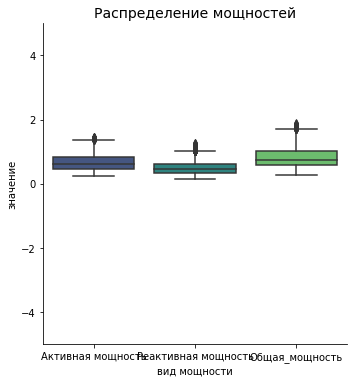

In [8]:
# Изменим интервал оси Y,чтобы поподробнее посмотреть распределение 
sns.catplot(kind="box", data=df_arc[['Активная мощность', 'Реактивная мощность','Общая_мощность']], palette='viridis', height=5)
plt.title('Распределение мощностей', fontsize=14)
plt.xlabel('вид мощности')
plt.ylabel('значение')
plt.ylim(-5,5)
plt.show()

In [9]:
df_arc.dtypes

key                       int64
Начало нагрева дугой     object
Конец нагрева дугой      object
Активная мощность       float64
Реактивная мощность     float64
Общая_мощность          float64
dtype: object

In [10]:
# рассчитаем продолжительность нагрева
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'],
                                                format='%Y-%m-%dT%H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'],
                                               format='%Y-%m-%dT%H:%M:%S')
df_arc['Время_нагрева_секунд'] = ((df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой'])
                                   .dt.total_seconds()
                                   .astype(int)
                                  )

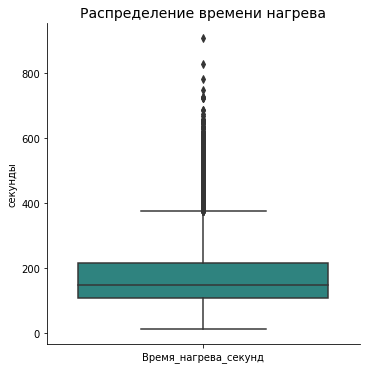

In [11]:
sns.catplot(kind="box", data=df_arc[['Время_нагрева_секунд']], palette='viridis', height=5)
plt.title('Распределение времени нагрева', fontsize=14)
plt.ylabel('секунды')
plt.show()

есть выбросы, думаю позже удалить значения более 800 секунд

Б. данные о подаче сыпучих материалов (объём)

In [12]:
display(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [13]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [14]:
df_bulk.isna().sum() #проверим пропуски

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

много пропусков. Вероятно, сыпучие используются не в каждом этапе производства. Думаю заполнить их нулями в дальнейшем

В. данные о подаче сыпучих материалов (время)

In [15]:
display(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [16]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [17]:
df_bulk.isna().sum() #проверим пропуски

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

много пропусков. Вероятно, сыпучие материалы используются не в каждом этапе производства. Думаю заполнить их нулями в дальнейшем

Г. данные о продувке сплава газом;

In [18]:
display(df_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [19]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [20]:
df_gas.isna().sum()

key      0
Газ 1    0
dtype: int64

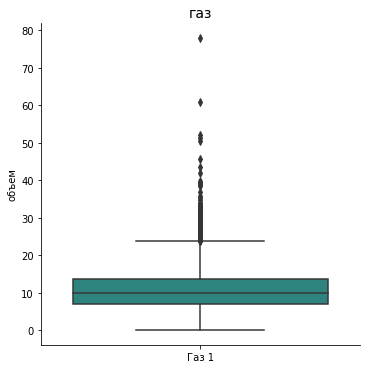

In [21]:
sns.catplot(kind="box", data=df_gas[['Газ 1']], palette='viridis', height=5)
plt.title('газ', fontsize=14)
plt.ylabel('объем')
plt.show()

Есть выбросы, думаю удалить то, что больше 60

Д. результаты измерения температуры

In [22]:
display(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [23]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [24]:
df_temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

есть пропуски, посмотрим, сколько их

In [25]:
t = df_temp.isna().sum().sort_values(ascending=False)[0]/len(df_temp)
print(f'Количество пропусков, столбец "temperature": \n{t:.0%}')

Количество пропусков, столбец "temperature": 
19%


Пропусков более 10%, это много, чтобы удалить все. Возможно, не на всех этапах делался замер температуры. В предобработке данных мы удалим данные, где только 1 замер, потому что нам надо начальная и конечная температура для признаков, необходимых для обучения модели. 

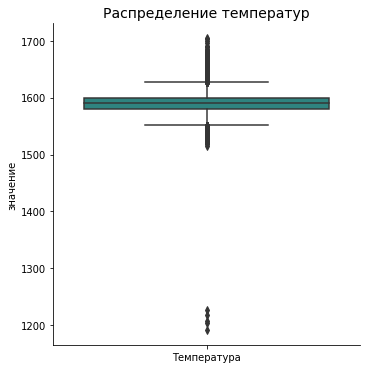

In [26]:
sns.catplot(kind="box", data=df_temp[['Температура']], palette='viridis', height=5)
plt.title('Распределение температур', fontsize=14)
plt.ylabel('значение')
plt.show()

есть выбросы, планирую удалить выбросы с температурой меньше 1450

Е.данные о проволочных материалах (объём)

In [27]:
display(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [29]:
df_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

много пропусков. Вероятно, проволочные материалы используются не в каждом этапе производства. Думаю заполнить их нулями в дальнейшем

Ж.данные о проволочных материалах (время)

In [30]:
display(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [32]:
df_wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

много пропусков. Вероятно, проволочные материалы используются не в каждом этапе производства. Думаю заполнить их нулями в дальнейшем

# Вывод:
1. В данных об электродах увидели выбросы по мощности, в дальнейшем удалим их;
2. Посчитали общую мощность;
3. Посчитали время нагрева;
4. В данных об электродах увидели выбросы по времени нагрева, в дальнейшем удалим их;
5. В данных по сыпучим материалам много пропусков, в рамках предобработки данных на основе информации, что сыпучие материалы подают не всегда, заполним их нулями;
6.В данных по проволочным материалам много пропусков, в рамках предобработки данных на основе информации, что сыпучие материалы подают не всегда, заполним их нулями;
7. В рамках нашей непосредственной задачи нам нет необходимости использовать данные по времени подачи сыпучих и проволочных материалов;
8. В предобраюотке данных мы удалим партии, в которых есть только 1 замер температуры в связи с невозможностью их использования для обучения модели.

Много пропусков в данных о проволочных и сыпучих материалах. Возможно, они используются не в каждом этапе производства.

План проекта:

1. Предобработка данных (с учетом ответов на уточняющие вопросы): заполнение пропусков, удаление ненужной для выполнения нашей задачи информации;
2. Объединение всех необходимых данных в одну таблицу по "key", одинаковому во всех таблицах;
3. Подготовить выборки (выделить целевой признак, разделить выборки на тестовую и тренировочную);
4. Обучение нескольких моделей на нашей выборке;
5. Выбор наиболее успешной модели, оценка ее на тестовой выборке, получение целевого показателя заданной метрики. 

Цель проекта:

построение модели, которая предскажет температуру стали, производимой ООО «Так закаляем сталь», которая позволит сократить потребление электроэнергии и соответственно производственные расходы.


2. Предобработка данных

А. данные об электродах

In [33]:
#уберем ненужные для дальнейшего исследования столбцы
df_arc=df_arc[['key', 'Время_нагрева_секунд', 'Общая_мощность']]
display(df_arc.describe())

,key,Время_нагрева_секунд,Общая_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,171.670946,0.871425
std,934.571502,98.186803,5.868339
min,1.000000,11.000000,0.275718
25%,806.000000,107.000000,0.578847
50%,1617.000000,147.000000,0.746591
75%,2429.000000,214.000000,1.030427
max,3241.000000,907.000000,715.480272


In [34]:
#уберем строки с аномальными значениями мощности
df_arc=df_arc.query('0<Общая_мощность<50')
display(df_arc.describe())

,key,Время_нагрева_секунд,Общая_мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,171.675160,0.823385
std,934.593897,98.188759,0.323470
min,1.000000,11.000000,0.275718
25%,806.000000,107.000000,0.578839
50%,1617.000000,147.000000,0.746554
75%,2429.000000,214.000000,1.030402
max,3241.000000,907.000000,1.898158


In [35]:
#уберем строки с аномальными значениями времени нагрева
df_arc=df_arc.query('Время_нагрева_секунд <800')
display(df_arc.describe())

,key,Время_нагрева_секунд,Общая_мощность
count,14873.000000,14873.000000,14873.000000
mean,1615.108788,171.581725,0.823330
std,934.614128,97.863040,0.323456
min,1.000000,11.000000,0.275718
25%,806.000000,107.000000,0.578821
50%,1616.000000,147.000000,0.746414
75%,2429.000000,214.000000,1.030258
max,3241.000000,780.000000,1.898158


In [36]:
# создадим таблицу c данными о количестве замеров
Количество_замеров = df_arc['key'].value_counts().reset_index(name='Количество_замеров').rename(columns={'index': 'key'})
display(Количество_замеров.isna().sum())

# добавим данные о количестве раундов в нашу табличку
df_arc = df_arc.groupby(by = 'key').sum()
df_arc = df_arc.merge(Количество_замеров, on='key')
display (df_arc.head())
display(df_arc.isna().sum())
display(df_arc.describe())

key                   0
Количество_замеров    0
dtype: int64

,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров
0,1,1098,3.718736,5
1,2,811,2.588349,4
2,3,655,5.019223,5
3,4,741,3.400038,4
4,5,869,2.816980,4


key                     0
Время_нагрева_секунд    0
Общая_мощность          0
Количество_замеров      0
dtype: int64

,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,1623.061294,794.005912,3.810013,4.627567
std,934.739859,329.893528,1.500575,1.607173
min,1.000000,57.000000,0.331897,1.000000
25%,817.250000,571.000000,2.775021,4.000000
50%,1623.500000,769.500000,3.694219,4.000000
75%,2431.750000,982.750000,4.696915,6.000000
max,3241.000000,3282.000000,14.466533,16.000000


Б. данные о подаче сыпучих материалов (объём)

In [37]:
#заполним пропуски нулями, так как там, где нет данных о подаче сыпучих материалов, эти материалы не подавались
df_bulk = df_bulk.fillna(0)
df_bulk.isna().sum()

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

In [38]:
# объединим таблицы по электродам и сыпучим материалам по ключу "key"
data=df_arc.merge(df_bulk, on='key')
display(data)

,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,1098,3.718736,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,811,2.588349,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,655,5.019223,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,741,3.400038,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,869,2.816980,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,3237,909,3.250657,5,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3124,3238,546,1.723937,3,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3125,3239,1216,6.014480,8,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3126,3240,839,4.082920,5,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


Г. данные о продувке сплава газом;

In [39]:
#уберем строки с аномальными значениями по газу
df_gas=df_gas.rename(columns={'Газ 1': 'Газ'})
df_gas=df_gas.query('Газ <60')
display(df_gas.describe())

,key,Газ
count,3237.000000,3237.000000
mean,1622.677479,10.965940
std,935.098456,6.046293
min,1.000000,0.008399
25%,814.000000,7.042268
50%,1623.000000,9.828795
75%,2432.000000,13.767550
max,3241.000000,52.142373


In [40]:
# объединим таблицы по электродам и сыпучим материалам с данными по газу по ключу "key"
data=data.merge(df_gas, on='key')
display(data)
display(data.describe())

,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ
0,1,1098,3.718736,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,811,2.588349,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,655,5.019223,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,741,3.400038,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,869,2.816980,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,3237,909,3.250657,5,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905
3120,3238,546,1.723937,3,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669
3121,3239,1216,6.014480,8,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518
3122,3240,839,4.082920,5,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,11.863103


,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ
count,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000
mean,1626.556658,801.301857,3.837147,4.662612,3.106274,1.782010,47.243278,33.804738,2.637964,21.853713,2.315621,0.015685,0.443982,4.692061,4.352433,203.548015,1.043534,152.561780,115.405570,11.157792
std,932.499148,324.501874,1.487436,1.587696,11.423621,21.234737,74.265331,55.996383,20.934611,55.478918,31.142976,0.876679,6.056760,20.172580,22.717078,148.588614,14.125485,80.614553,84.465495,6.010865
min,1.000000,57.000000,0.331897,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399
25%,819.750000,581.000000,2.809329,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,7.191058
50%,1625.500000,777.000000,3.721970,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,9.947275
75%,2432.250000,987.000000,4.722963,6.000000,0.000000,0.000000,79.250000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,13.872336
max,3241.000000,3282.000000,14.466533,16.000000,118.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,853.000000,305.000000,601.000000,405.000000,52.142373


Д. результаты измерения температуры

In [41]:
# удалим строки с аномальными значениями по температуре
df_temp = df_temp.query('Температура > 1450')
display(df_temp.describe())
display(df_temp.head())

,key,Температура
count,14660.000000,14660.000000
mean,1325.369236,1590.852729
std,787.407873,19.143141
min,1.000000,1515.000000
25%,654.000000,1580.000000
50%,1314.000000,1590.000000
75%,1962.250000,1599.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [42]:
# создадим новый столбец
df_temp_count = df_temp.groupby('key').count()
df_temp_count['Количество_замеров'] = df_temp_count[['Температура']]
df_count_temp = df_temp_count[['Количество_замеров']]
display(df_count_temp.head())

# объединим таблицы
df_count_temp = df_count_temp.reset_index(drop=False)
df_temp = df_temp.merge(df_count_temp, on='key')
display(df_temp.tail())

,Количество_замеров
key,
1,6
2,5
3,6
4,5
5,5


,key,Время замера,Температура,Количество_замеров
14655,3237,2019-09-06 11:31:15,1569.0,1
14656,3238,2019-09-06 12:16:15,1584.0,1
14657,3239,2019-09-06 14:16:50,1598.0,1
14658,3240,2019-09-06 15:25:21,1617.0,1
14659,3241,2019-09-06 16:48:55,1586.0,1


In [43]:
# уберем партии с одним замером, так как для подготовки выборки нам нужна начальная и конечная температура
df_temp = df_temp.query('Количество_замеров > 1')
display(df_temp.tail())
display(df_temp.describe())

,key,Время замера,Температура,Количество_замеров
13917,2499,2019-08-10 13:33:21,1569.0,5
13918,2499,2019-08-10 13:41:34,1604.0,5
13919,2499,2019-08-10 13:46:28,1593.0,5
13920,2499,2019-08-10 13:54:56,1588.0,5
13921,2499,2019-08-10 13:58:58,1603.0,5


,key,Температура,Количество_замеров
count,13920.000000,13920.000000,13920.000000
mean,1243.619181,1590.911494,6.085489
std,719.133465,18.774355,1.740807
min,1.000000,1515.000000,2.000000
25%,624.000000,1580.000000,5.000000
50%,1246.000000,1590.000000,6.000000
75%,1870.000000,1599.000000,7.000000
max,2499.000000,1705.000000,17.000000


Сформируем таблицы со значениями температуры при первом и последнем замере (в дальнейшем эти данные будут использоваться при обучении моделей)

In [44]:
# создадим сводную таблицу с первым замером
data_temp_first = df_temp.pivot_table(index = ["key"],
                                      values = "Время замера", 
                                      aggfunc = "first")

data_temp_first = (data_temp_first
                   .merge(df_temp, on='Время замера')
                   .set_index('key')
                   .rename(columns={"Температура": "Первый_замер"})
                   .drop(['Время замера','Количество_замеров'] , axis=1)
                 )

# создадим сводную таблицу с последним замером
data_temp_last = df_temp.pivot_table(index = ["key"],
                                     values = "Время замера",
                                     aggfunc = "last")

data_temp_last = (data_temp_last.merge(df_temp, on='Время замера')
                  .set_index('key')
                  .rename(columns={"Температура": "Последний_замер"})
                  .drop(['Время замера','Количество_замеров'] , axis=1)
                 )

# объединим 2 таблицы
data_temp_final = data_temp_first.merge(data_temp_last, on='key')
display(data_temp_final)

,Первый_замер,Последний_замер
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


In [45]:
# объединим таблицы по электродам, сыпучим материалам, газу с данными по температуре по ключу "key"
data=data.merge(data_temp_final, on='key')
data = data.query('Количество_замеров > 1')
display(data.head())
display(data.describe())

,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ,Первый_замер,Последний_замер
0,1,1098,3.718736,5,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0
1,2,811,2.588349,4,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0
2,3,655,5.019223,5,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0
3,4,741,3.400038,4,0.0,0.0,0.0,81.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0
4,5,869,2.816980,4,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0


,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ,Первый_замер,Последний_замер
count,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,...,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000,2378.000000
mean,1253.609336,813.299411,3.884035,4.697225,3.279226,1.393188,46.320437,36.259041,2.585786,21.921362,...,0.409167,4.948696,4.092515,210.394870,1.045416,154.680404,118.024811,11.258337,1588.230446,1594.939445
std,715.671031,326.703800,1.476607,1.550442,11.714968,18.885495,74.915776,58.242311,22.173362,55.290423,...,6.021239,20.713521,22.187138,152.229257,14.088385,80.461676,85.233090,6.112288,24.515548,14.987265
min,1.000000,119.000000,0.799281,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000
25%,637.250000,592.000000,2.847996,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,106.000000,0.000000,105.000000,0.000000,7.243169,1571.000000,1587.000000
50%,1254.500000,782.000000,3.754065,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,106.000000,10.016304,1587.000000,1593.000000
75%,1867.750000,993.000000,4.741831,6.000000,0.000000,0.000000,77.750000,75.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,290.000000,0.000000,204.000000,204.000000,14.049159,1604.000000,1599.000000
max,2499.000000,3282.000000,14.466533,16.000000,94.000000,325.000000,454.000000,281.000000,603.000000,503.000000,...,147.000000,159.000000,313.000000,853.000000,305.000000,601.000000,405.000000,52.142373,1679.000000,1696.000000


Е.данные о проволочных материалах (объём)

In [46]:
#заполним пропуски нулями, так как там, где нет данных о подаче проволочных материалов, эти материалы не подавались
df_wire = df_wire.fillna(0)
df_wire.isna().sum()

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

In [47]:
# объединим таблицы по электродам, сыпучим материалам, газу, температуре с данными по проволочным материалам по ключу "key"
data=data.merge(df_wire, on='key')
display(data.head())
display(data.describe())
display(data.isna().sum())

,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Последний_замер,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1098,3.718736,5,0.0,0.0,0.0,43.0,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,2.588349,4,0.0,0.0,0.0,73.0,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,5.019223,5,0.0,0.0,0.0,34.0,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,3.400038,4,0.0,0.0,0.0,81.0,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,2.816980,4,0.0,0.0,0.0,78.0,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Последний_замер,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,...,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.0,2302.000000,2302.000000,2302.000000,2302.00000
mean,1253.067333,813.205474,3.914167,4.729366,3.387489,1.439183,47.595135,37.410947,2.671156,22.458732,...,1593.408775,102.563049,17.424288,3.272858,0.310145,0.0,0.990301,0.006435,0.294979,0.30347
std,714.227842,329.337637,1.480237,1.554514,11.891447,19.193122,75.597963,58.805040,22.531508,55.904423,...,11.191361,43.404584,33.356801,28.104124,4.785462,0.0,8.743504,0.206907,4.324654,3.37690
min,1.000000,119.000000,0.799281,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1541.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
25%,633.250000,587.250000,2.871369,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1587.000000,74.037598,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
50%,1255.500000,782.000000,3.784130,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1593.000000,101.119202,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
75%,1867.750000,995.000000,4.776990,6.000000,0.000000,0.000000,80.000000,78.000000,0.000000,0.000000,...,1598.000000,128.086140,23.028460,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
max,2499.000000,3282.000000,14.466533,16.000000,94.000000,325.000000,454.000000,281.000000,603.000000,503.000000,...,1653.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.02560


key                     0
Время_нагрева_секунд    0
Общая_мощность          0
Количество_замеров      0
Bulk 1                  0
Bulk 2                  0
Bulk 3                  0
Bulk 4                  0
Bulk 5                  0
Bulk 6                  0
Bulk 7                  0
Bulk 8                  0
Bulk 9                  0
Bulk 10                 0
Bulk 11                 0
Bulk 12                 0
Bulk 13                 0
Bulk 14                 0
Bulk 15                 0
Газ                     0
Первый_замер            0
Последний_замер         0
Wire 1                  0
Wire 2                  0
Wire 3                  0
Wire 4                  0
Wire 5                  0
Wire 6                  0
Wire 7                  0
Wire 8                  0
Wire 9                  0
dtype: int64

Отметим особенности распределения данных

In [48]:
data.describe()

,key,Время_нагрева_секунд,Общая_мощность,Количество_замеров,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Последний_замер,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,...,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000,2302.0,2302.000000,2302.000000,2302.000000,2302.00000
mean,1253.067333,813.205474,3.914167,4.729366,3.387489,1.439183,47.595135,37.410947,2.671156,22.458732,...,1593.408775,102.563049,17.424288,3.272858,0.310145,0.0,0.990301,0.006435,0.294979,0.30347
std,714.227842,329.337637,1.480237,1.554514,11.891447,19.193122,75.597963,58.805040,22.531508,55.904423,...,11.191361,43.404584,33.356801,28.104124,4.785462,0.0,8.743504,0.206907,4.324654,3.37690
min,1.000000,119.000000,0.799281,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1541.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
25%,633.250000,587.250000,2.871369,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1587.000000,74.037598,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
50%,1255.500000,782.000000,3.784130,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1593.000000,101.119202,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
75%,1867.750000,995.000000,4.776990,6.000000,0.000000,0.000000,80.000000,78.000000,0.000000,0.000000,...,1598.000000,128.086140,23.028460,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
max,2499.000000,3282.000000,14.466533,16.000000,94.000000,325.000000,454.000000,281.000000,603.000000,503.000000,...,1653.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.02560


    Среднее время нагрева - 813 сек., минимальное - 119, максимальное - 3282
    Средняя общая мощность - 3,91, минимальная - 0,80, максимальное - 14,47
    Среднее количество замеров - 5, минимальное - 2, максимальное - 16            
    Средняя температура первого замера - 1587, минимальная - 1519, максимальная - 1660
    Средняя температура последнего замера - 1593, минимальная - 1541, максимальная - 1653
    Среднее количество газа - 11,37, минимальное - 0,01, максимальное - 52,14

Посмотрим корреляцию признаков по тепловой карте

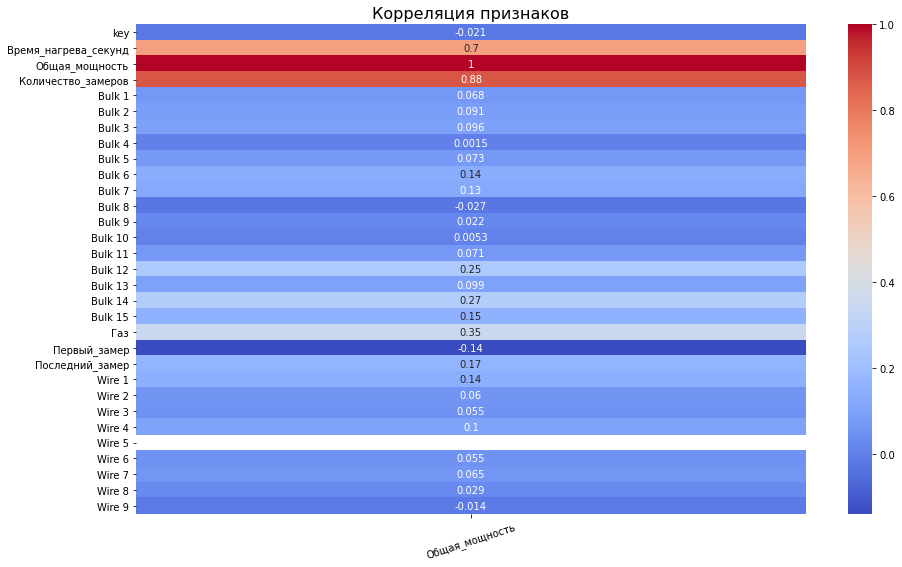

In [49]:
#посмотрим коррреляцию общей мощности с остальными признаками
plt.figure(figsize=(15, 9))
fig = sns.heatmap(data.corr()[['Общая_мощность']], cmap='coolwarm', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

наблюдается высокая корреляция (больше 0,7) общей мощности с временем нагрева и количеством замеров (они же раунды нагрева)

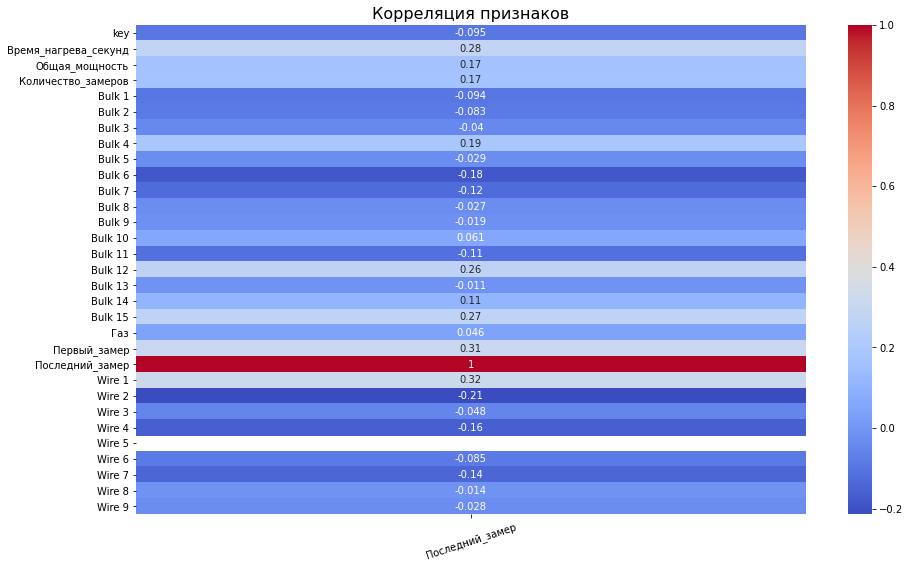

In [50]:
#посмотрим коррреляцию температуры последнего замера с остальными признаками
plt.figure(figsize=(15, 9))
fig = sns.heatmap(data.corr()[['Последний_замер']], cmap='coolwarm', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

высокой корреляции не наблюдается/ 
наблюдается слабая корреляция (0,3) между температурой последнего и первого замера и 0,32 - между температурой последнего замера и добавлением Wire 1/ 
наблюдается очень слабая, но все же заметная корреляция между температурой последнего замера и временем нагрева, добавлением Bulk12 и 15,4, а также с общей мощностью и количеством замеров

# Вывод:
1. Заполнили пропуски по сыпучим и проволочным материалам нулями, так как, где нет данных в этих столбцах, там этим материалы не добавлялись;
2. Удалили строки с аномальными значениями по мощности, температуре, газу, времени нагрева;
3. Добавили количество замеров, удалили партии с 1 замером, как нет необходимой для дальнейшего анализа начальной и конечной температуры;
4. Добавили данные по температуре первого и последнего замера;
5. Объединили все необходимые для обучения моделей данные в одну таблицу по key
6. Отметили особенности распределения данных;
7. Отметили высокую корреляцию (больше 0,7) общей мощности с временем нагрева и количеством замеров(раундов нагрева);
8. Отметили, что наблюдается слабая корреляция (0,3) между температурой последнего и первого замера и 0,32 - между температурой последнего замера и добавлением Wire 1/ наблюдается очень слабая, но все же заметная корреляция между температурой последнего замера и временем нагрева, добавлением Bulk12 и 15,4, а также с общей мощностью и количеством замеров.

3.Создание выборок и обучение моделей

3.1.Создание выборок

In [51]:
#Уберем неинформативный признак key из нашей таблички перед разбиением на выборки
data=data.drop('key', axis=1)

In [52]:
# Разбиваем исходные данные на обучающую(75%) и тестовую выборки(25%)
features = data.drop('Последний_замер', axis=1)
target = data['Последний_замер']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True
)

print(features_train.shape)
print(target_test.shape)

(1726, 29)
(576,)


In [53]:
# КОД ТИМЛИДА
features.columns

Index(['Время_нагрева_секунд', 'Общая_мощность', 'Количество_замеров',
       'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15', 'Газ', 'Первый_замер', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

3.2. Обучение моделей

Обучу несколько моделей, которые ранее показывали себя с хорошей стороны:
RandomForestRegressor,
LGBMRegressor,
CatBoostRegressor

А.RandomForestRegressor 

In [54]:
%%time
model = RandomForestRegressor()
params = {
    'n_estimators': [10, 30, 80],
    'max_depth': [5, 10, 20],
    'min_samples_split': [1, 3, 7],
    'bootstrap': [True, False],
    'random_state': [RANDOM_STATE]
}
rf_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
rf_grid.fit(features_train, target_train)
result = abs(rf_grid.best_score_)
print(f'MAE: {result:.2f}')

MAE: 6.20
CPU times: user 1min 12s, sys: 269 ms, total: 1min 12s
Wall time: 1min 13s


Б.LGBMRegressor

In [ ]:
%%time
model = LGBMRegressor()
params = {
    'metric': ['mae'],
    'max_depth': [5, 10, 20], 
    'num_leaves': [8, 20, 50],  
    'learning_rate': [0.01, 0.05, 0.1],
    'random_state': [RANDOM_STATE],
}
lgbm_grid = GridSearchCV(model, params, cv=5, verbose=2)
lgbm_grid.fit(features_train, target_train)
train_predictions = lgbm_grid.predict(features_train)
result = mean_absolute_error(target_train, train_predictions)
print(f'MAE: {result:.2f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=   9.3s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=   5.5s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  17.2s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=   4.0s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=   4.2s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=   8.1s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  13.7s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  13.2s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  24.8s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=   6.0s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=   9.7s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=  17.5s
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  44.7s
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  28.3s
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  45.0s
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  32.0s
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  24.3s
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time= 1.6min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time= 2.1min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time= 3.1min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time= 3.4min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time= 1.6min
[CV] END learning_rate=0.01, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time=  19.7s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   7.3s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   4.5s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   4.0s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=   7.5s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=   9.6s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  35.1s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  39.7s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  44.6s
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 2.5min
[CV] END learning_rate=0.01, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.3min
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  24.7s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  22.1s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  17.2s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  17.6s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=   8.4s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  23.2s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  20.3s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  37.1s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  42.4s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  26.3s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=  55.9s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=  34.2s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=  35.5s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time= 1.2min
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=  38.2s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  16.7s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  24.6s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  16.5s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  31.6s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  16.0s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  39.6s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  36.3s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  35.1s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  32.2s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  44.8s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time= 1.4min
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time= 1.0min
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time=  42.6s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time= 1.3min
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time=  45.1s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   3.3s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   5.4s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   9.7s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=   3.7s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  10.7s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=   7.4s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=   7.4s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=   6.2s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  11.0s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time=  19.6s
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.2min
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.3min
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 2.6min
[CV] END learning_rate=0.05, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 2.1min
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  14.8s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  40.3s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  12.5s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  43.7s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=8, random_state=310723; total time=  27.4s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  45.9s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  38.5s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  58.7s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=20, random_state=310723; total time=  22.4s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time= 1.0min
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time= 1.2min
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=  46.2s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=  28.0s
[CV] END learning_rate=0.1, max_depth=5, metric=mae, num_leaves=50, random_state=310723; total time=  38.4s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  27.0s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  18.5s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  18.3s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  15.3s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=8, random_state=310723; total time=  23.3s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  43.4s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  31.9s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  38.7s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time=  41.5s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=20, random_state=310723; total time= 2.1min
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time=  37.4s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time=  44.3s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time=  52.1s
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time= 1.1min
[CV] END learning_rate=0.1, max_depth=10, metric=mae, num_leaves=50, random_state=310723; total time=  46.4s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=  25.3s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=  22.1s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=  12.9s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=  23.4s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=8, random_state=310723; total time=  19.4s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  27.1s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  41.3s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  56.7s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time=  54.1s
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=20, random_state=310723; total time= 1.0min
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 2.7min
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 2.0min
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.8min
[CV] END learning_rate=0.1, max_depth=20, metric=mae, num_leaves=50, random_state=310723; total time= 1.5min
MAE: 5.37
CPU times: user 1h 38min 41s, sys: 45.5 s, total: 1h 39min 27s
Wall time: 1h 40min 9s



В. CatBoostRegressor

In [55]:
%%time
model = CatBoostRegressor(verbose=False)
params = {        
    'loss_function':['MAE'],
    'depth': [5],   # проверяла [5, 10, 15], случайно нажала еще раз на яйчейку, а модель обучается больше 3 часов, но были выведены лучшие параметры до повторного нажатия
    'learning_rate': [0.05],  # проверяла  [0.01, 0.05, 0.1]
    'n_estimators': [150], # проверяла  [50, 100, 150]
    'random_state': [RANDOM_STATE],
}
cb_grid = GridSearchCV(model, params, cv=5, verbose=2)
cb_grid.fit(features_train, target_train)
train_predictions = cb_grid.predict(features_train)
result = mean_absolute_error(target_train, train_predictions)
print(f'MAE: {result:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END depth=5, learning_rate=0.05, loss_function=MAE, n_estimators=150, random_state=310723; total time=   1.7s
[CV] END depth=5, learning_rate=0.05, loss_function=MAE, n_estimators=150, random_state=310723; total time=   1.2s
[CV] END depth=5, learning_rate=0.05, loss_function=MAE, n_estimators=150, random_state=310723; total time=   1.3s
[CV] END depth=5, learning_rate=0.05, loss_function=MAE, n_estimators=150, random_state=310723; total time=   1.2s
[CV] END depth=5, learning_rate=0.05, loss_function=MAE, n_estimators=150, random_state=310723; total time=   1.2s
MAE: 5.21
CPU times: user 2.27 s, sys: 93 ms, total: 2.36 s
Wall time: 8.2 s


Самый лучший MAE у CatBoostRegressor - 5,21, у LGBMRegressor ненамного хуже, при этом время обучения LGBMRegressor значительно меньше.

3.3. Проверим лучшую модель на тестовой выборке

CatBoostRegressor

In [56]:
%%time
predictions = cb_grid.predict(features_test)
result = mean_absolute_error(target_test, predictions)
print(f'MAE test: {result:.2f}')

MAE test: 6.35
CPU times: user 5.58 ms, sys: 23 µs, total: 5.6 ms
Wall time: 4.24 ms


In [57]:
%%time
params = {        
    'loss_function':'MAE',
    'depth': 5,
    'learning_rate': 0.05,
    'n_estimators': 150,
    'random_state': RANDOM_STATE,
    'verbose' : 0
}
model = CatBoostRegressor(**params)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = mean_absolute_error(target_test, predictions)
print(f'MAE test: {result:.2f}')

MAE test: 6.35
CPU times: user 450 ms, sys: 27.4 ms, total: 477 ms
Wall time: 2.31 s


MAE на тестовой выборке у CatBoostRegressor - 6.35 время предсказаний - 4,24

In [57]:
cb_grid.best_params_

{'depth': 5,
 'learning_rate': 0.05,
 'loss_function': 'MAE',
 'n_estimators': 150,
 'random_state': 310723}

3.4. Сделаем итоговую таблицу по всем моделям и MAE для наглядности и удобства анализа

In [58]:
models = []
our_models = pd.DataFrame(data=models, index=['RandomForestRegressor', 'LGBMRegressor', 'CatBoost'], columns=['MAE train', 'MAE test','predictions_time'])

display(our_models)

,MAE train,MAE test,predictions_time
RandomForestRegressor,NaN,NaN,NaN
LGBMRegressor,NaN,NaN,NaN
CatBoost,NaN,NaN,NaN


In [62]:
our_models['MAE train']=[6.20, 5.37, 5.21]
our_models['MAE test']=[0, 0, 6.35]
our_models['predictions_time']=[0,0 , 4.24]
display(our_models)

,MAE train,MAE test,predictions_time
RandomForestRegressor,6.20,0.00,0.00
LGBMRegressor,5.37,0.00,0.00
CatBoost,5.21,6.35,4.24


3.5. Проверим модель на адекватность с помощью константной модели

In [60]:
%%time
dummy_regr = DummyRegressor(strategy = "median")
dummy_regr.fit(features_train, target_train)
predict = dummy_regr.predict(features_test)
MAE_dummy = mean_absolute_error(target_test, predict)
print('MAE константной модели:', MAE_dummy)


MAE константной модели: 8.350694444444445
CPU times: user 1.85 ms, sys: 36 µs, total: 1.89 ms
Wall time: 1.43 ms


MAE константной модели больше, чем нашей. Значит, наша модель адекватна

3.6. Отобразим значимость признаков для модели

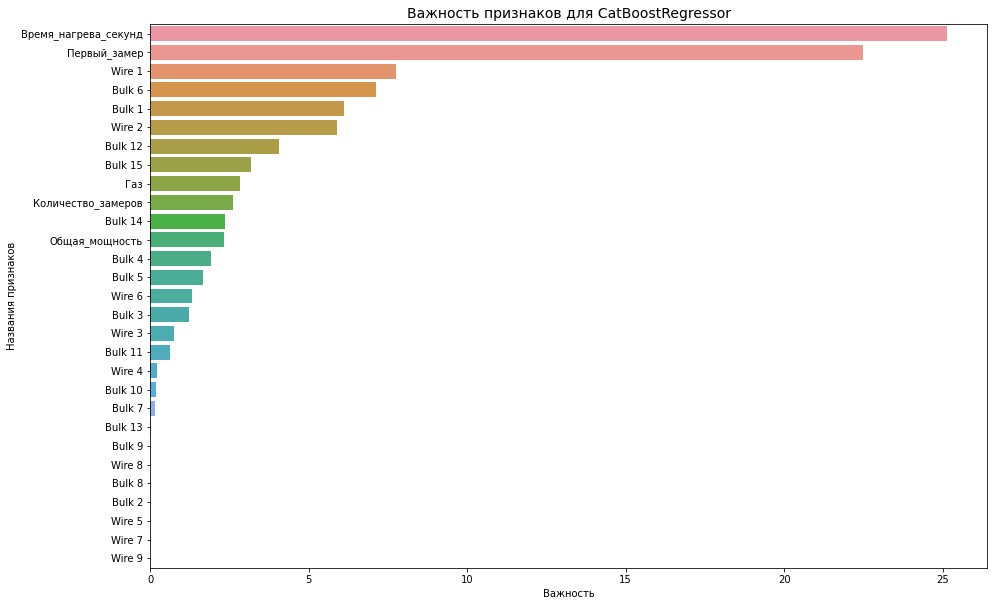

CPU times: user 727 ms, sys: 68.2 ms, total: 795 ms
Wall time: 2.13 s


In [63]:
%%time
#обучим модель с лучшими параметрами (отображены в пункте 3.3)
model = CatBoostRegressor(
    depth=5,
    learning_rate=0.05,
    loss_function='MAE',
    n_estimators=150,
    random_state=310723,
    verbose = False
)

model.fit(features_train, target_train)

#построим график значимости признаков нашей модели
plot_data = {
    'features': features_test.columns,
    'feature_importances': model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(15, 10))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Важность')
plt.ylabel('Названия признаков')
plt.show()


Наиболее значимыми для нашей модели являются время нагрева и температура первого замера. Также значимы общая можность, количество замеров, добавление газов и определенных примесей

# Вывод:

1. У модели CatBoostRegressor лучшее из 3 моделей MAE на тренировочной выборке и самое длинное время обучения;
2. У модели CatBoostRegressor MAE 6,35 на тестовых данных, что соответствует условиям заказчика;
3. MAE константной модели больше, чем нашей. Значит, наша модель адекватна;
4. Наиболее значимыми для нашей модели являются время нагрева и температура первого замера. Также значимы общая можность, количество замеров, добавление газов и определенных примесей.

# Общий вывод:

На основании предоставленных заказчиком ООО «Так закаляем сталь» данных после проведенной предобработки мы обучили несколько моделей. Затем оценили их с помощью метрики MAE на тренировочной, а лучшую модель и на тестовой выборке. Также наша модель прошла проверку на адекватность.

На основании анализа результатов самой лучшей моделью выбрана CatBoostRegressor с MAE=6.35 на тестовой выборке, что соответствует условиям заказчика.


# 4. Отчет о проделанной работе

4.1. Какие пункты плана были выполнены, а какие — нет. Почему?

Все пункты плана удалось выполнить. Дополнительно посмотрела корреляцию признаков между собой, проверила лучшую модель на адекватность с помощью константной модели, построила график значимости признаков нашей модели. Дополнительные действия были совершены для более полного анализа данных, а расчет MAE константной модели - для проверки адекватности нашей модели.

4.2. Какие трудности возникли и как вы их преодолели?

Не очень понятен был технологический процесс сначала, но после ответов Вячеслава на уточняющие вопросы стало понятнее.
Не сталкивалась ранее с графиками значимости признаков. Нашла в интернете примеры, как это делается. 

4.3. Какие ключевые шаги в решении задачи вы выделили?

    1. Обсуждение технологического процесса.
    2. Первоначальный исследовательский анализ данных: просмотр файлов с данными, проверка пропусков, изучение распределений значений признаков, выявление аномалий.
    3. Предобработка данных: заполнение пропусков, удаление выбросов, удаление ненужных в нашем исследовании данных, добавление столбцов с необходимыми в нашем исследовании данными (также расчет этих дополнительных данных), объединение данных в одну таблицу по ключу key.
    4. Изучение распределения данных в общей таблице, изучение корреляции признаков.
    5. Выделение признаков, разделение данных на выборки для дальнейшего обучения моделей.
    6. Подбор лучших гиперпараметров и обучение 3 моделей: RandomForestRegressor,LGBMRegressor,CatBoostRegressor.
    7. Проверка лучшей модели на тестовой выборке.
    8. Проверка нашей модели на адекватность с помощью константной модели.
    9. Отображение значимость признаков для модели.

4.4.Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

Использовала следующие признаки в качестве features: 'Время_нагрева_секунд', 'Общая_мощность', 'Количество_замеров',
       'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15', 'Газ', 'Первый_замер', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'/

В качестве target использовала 'Последний_замер'(конечную температуру).

По примесям в ходе предобработки я заполняла пропуски нулями.
По 'Время_нагрева_секунд', 'Общая_мощность','Газ', 'Первый_замер','Последний_замер' - удаляла аномальные значения.
По 'Количество_замеров' - удалила данные, где только 1 замер, так как для обучения моделей нам нужны были данные по первому и последнему замеру, то есть, как минимум, 2 замера необходимы.

4.5. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

Самой лучшей моделью выбрана CatBoostRegressor с MAE=6.35 на тестовой выборке, что соответствует условиям заказчика.
Ее гиперпараметры:
    depth=5,
    learning_rate=0.05,
    loss_function='MAE',
    n_estimators=150,
    random_state=310723,
    verbose = False